<a href="https://colab.research.google.com/github/IdajiliJohnOjochegbe/stock-price-prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/content/drive/MyDrive/GS.csv')


In [2]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-05-04,76.0000,77.250,70.0000,70.3750,53.576797,22320900
1,1999-05-05,69.8750,69.875,66.2500,69.1250,52.625153,7565700
2,1999-05-06,68.0000,69.375,67.0625,67.9375,51.721100,2905700
3,1999-05-07,67.9375,74.875,66.7500,74.1250,56.431648,4862300
4,1999-05-10,73.3750,73.500,70.2500,70.6875,53.814709,2589400


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5762 non-null   object 
 1   Open       5762 non-null   float64
 2   High       5762 non-null   float64
 3   Low        5762 non-null   float64
 4   Close      5762 non-null   float64
 5   Adj Close  5762 non-null   float64
 6   Volume     5762 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 315.2+ KB


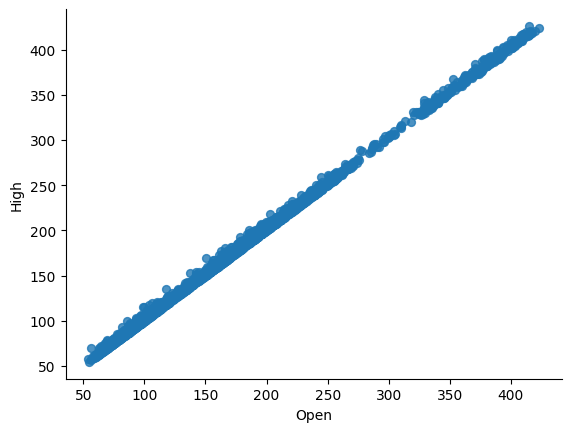

In [4]:
# @title Open vs High

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
# prompt: Using dataframe data:

data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-05-04,76.0000,77.250,70.0000,70.3750,53.576797,22320900
1,1999-05-05,69.8750,69.875,66.2500,69.1250,52.625153,7565700
2,1999-05-06,68.0000,69.375,67.0625,67.9375,51.721100,2905700
3,1999-05-07,67.9375,74.875,66.7500,74.1250,56.431648,4862300
4,1999-05-10,73.3750,73.500,70.2500,70.6875,53.814709,2589400


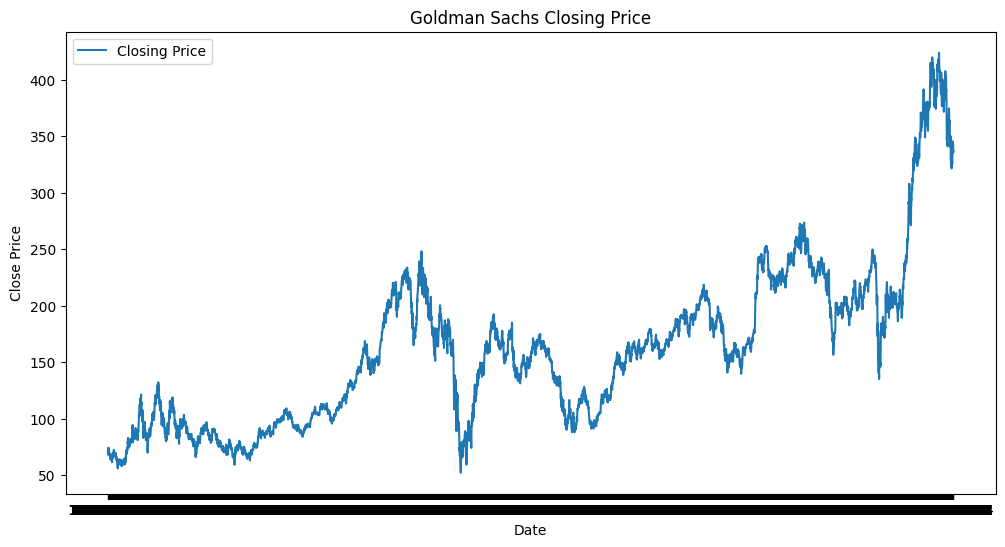

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Goldman Sachs Closing Price')
plt.legend()
plt.show()



# Data exploration and preprocessing

In [7]:
#checking for missing values

print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [8]:
data['Date'] =  pd.to_datetime(data['Date'])

In [9]:
data.set_index('Date', inplace = True)

<function matplotlib.pyplot.show(close=None, block=None)>

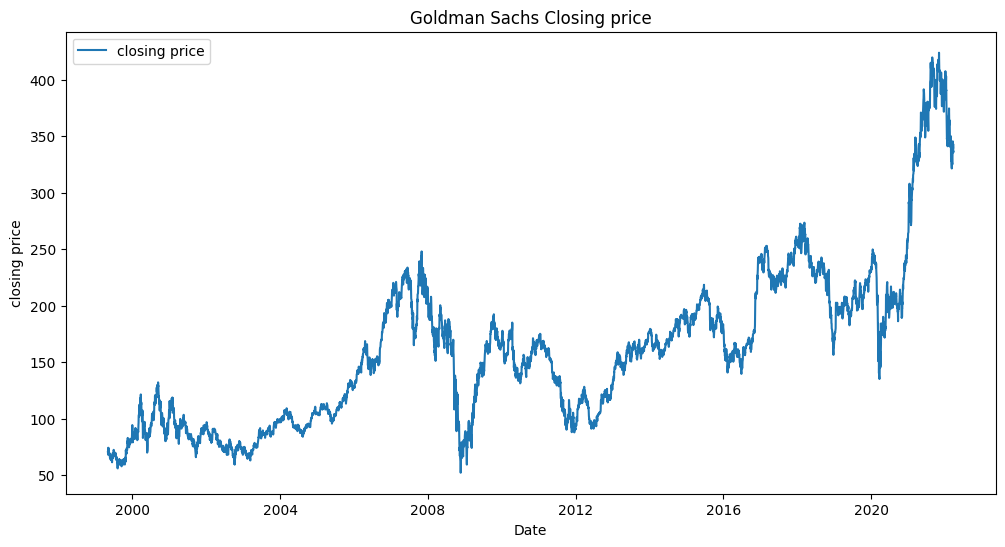

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label = 'closing price')
plt.xlabel('Date')
plt.ylabel('closing price')
plt.title('Goldman Sachs Closing price')
plt.legend()
plt.show

# Feature Engineering

# 1. Create Technical indicators

<function matplotlib.pyplot.show(close=None, block=None)>

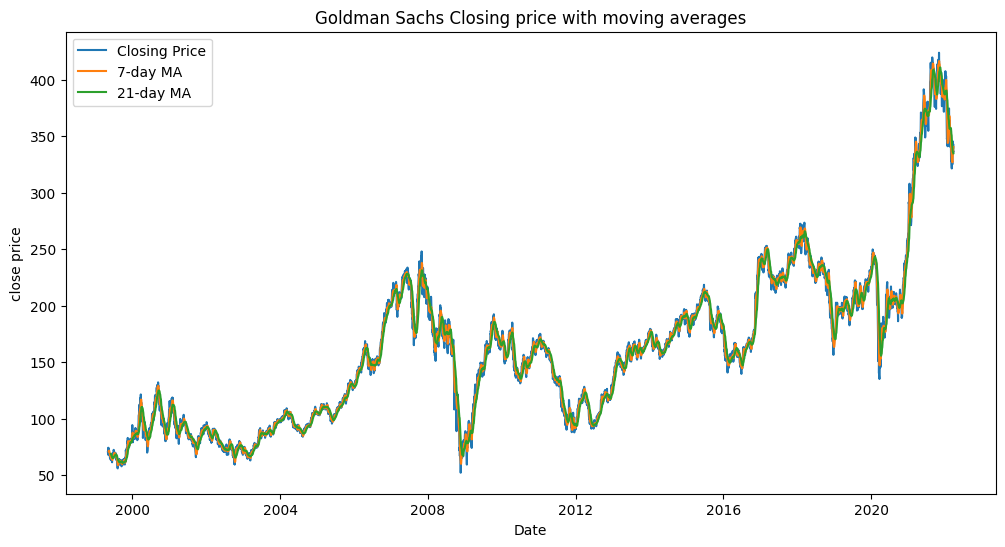

In [14]:
#calculate moving averages
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_21'] = data['Close'].rolling(window=21).mean()

#plot the closing price with moving averages
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Closing Price')
plt.plot(data.index, data['MA_7'], label='7-day MA')
plt.plot(data.index, data['MA_21'], label = '21-day MA')
plt.xlabel('Date')
plt.ylabel('close price')
plt.title('Goldman Sachs Closing price with moving averages')
plt.legend()
plt.show

# prepare data for training

In [15]:
#split the data into training and test set
train_size = int(len(data)*0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"The train data size is {len(train_data.shape)}")
print(f"The test data size is {len(test_data.shape)}")

The train data size is 2
The test data size is 2


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Create scaled training and test sets
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

# create the LSTM model

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare the data for LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)


4548/4548 [==============================] - 161s 34ms/step - loss: 3.5702e-04


# Model evaluation

In [22]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE
import math
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


35/35 [==============================] - 1s 26ms/step
Train RMSE: 139.517608092224
Test RMSE: 252.77514122062541


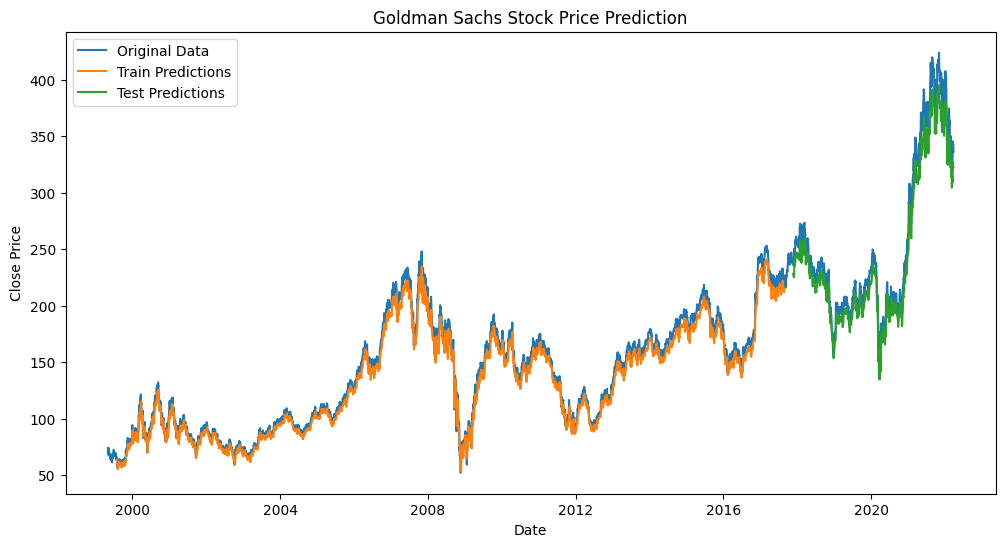

In [23]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(data.index[time_step:len(train_predict)+time_step], train_predict, label='Train Predictions')
plt.plot(data.index[len(train_predict)+(time_step*2)+1:len(data)-1], test_predict, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.legend()
plt.show()
